### **Imports**

In [1]:
import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.optim import lr_scheduler
import numpy as np
# import torchvision
# from torch.utils.data.dataloader import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
# import time
import os
# import copy
# import pathlib
# from torchvision.datasets import ImageFolder
# from torch.utils.data import random_split
# from torchvision.models import ResNet18_Weights
from PIL import Image
import PIL
# from torch.autograd import Variable
# import pandas as pd
import cv2 as cv
import tensorflow as tf
# from keras.models import Model

# from keras.applications.vgg16 import VGG16
# from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.models import load_model
import keras.optimizers
import numpy as np
# from glob import glob
import matplotlib.pyplot as plt
# from keras.preprocessing.image import load_img, img_to_array
# from torch.utils.data import DataLoader, Dataset
from datetime import datetime
from keras.callbacks import ModelCheckpoint
import tensorflow as tf
# from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import ResNet50V2, preprocess_input
# from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

class_labels = [
    "combat",
    "destroyedbuilding",
    "fire",
    "humanitarianaid",
    "militaryvehicles",
]
IMG_SIZE = (90, 90)
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


/home/srikar/miniconda3/envs/GG_1240/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(
2024-01-31 18:29:21.133802: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-31 18:29:21.173920: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-31 18:29:21.173974: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plug

cpu


### **Preprocess**

In [2]:
transform = transforms.Compose(
    [
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)


def preprocess_and_display(image_path):
    img = Image.open(image_path)
    input_tensor = transform(img)
    input_batch = input_tensor.unsqueeze(0)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    input_batch = input_batch.to(device)

    # plt.imshow(input_tensor.permute(1, 2, 0))
    # plt.show()
    if display:
        numpy_img = input_tensor.permute(1, 2, 0).numpy()
        numpy_img = cv.cvtColor(numpy_img, cv.COLOR_BGR2RGB)
        cv.imshow("Preprocessed Image", numpy_img)
        cv.waitKey(200)
        cv.destroyAllWindows()

    return input_batch


In [3]:
train_data_dir = "/mnt/Storage/Dataset/Training"
test_data_dir = "/mnt/Storage/Dataset/Testing"


### **Augmentation**

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.02,
    zoom_range=0.01,
    horizontal_flip=1,
    brightness_range=(0.1, 1.9),
    fill_mode="constant",
    cval=255,
    preprocessing_function = preprocess_input
)
test_datagen = ImageDataGenerator(
    rotation_range=3,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.02,
    zoom_range=0.01,
    horizontal_flip=1,
    brightness_range=(0.1, 1.9),
    fill_mode="constant",
    cval=255,
    preprocessing_function = preprocess_input
)


In [10]:
i = 1
for batch in train_datagen.flow_from_directory(
    directory="/mnt/Storage/Dataset/Training",
    batch_size=16,
    target_size=IMG_SIZE,
    color_mode="rgb",
    save_to_dir="/mnt/Storage/Dataset/aug",
    save_prefix="ag",
    save_format="jpg",
):
    i += 1
    if i > 0:
        break


Found 1756 images belonging to 5 classes.


In [11]:
print(keras.__version__)
print(tf.__version__)


2.15.0
2.15.0


### **Training**

In [12]:
# Define constants
NUM_CLASSES = 5
BATCH_SIZE = 32
EPOCHS = 1
LR = 0.0001

TRAIN_DIR = train_data_dir
TEST_DIR = test_data_dir

# Load the ResNet50 model with pre-trained weights
base_model = ResNet50V2(
    weights="imagenet", include_top=False, input_shape=IMG_SIZE + (3,)
)

# Freeze the layers in base model
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top
model = Sequential()
model.add(base_model)
model.add(tf.keras.layers.GlobalAveragePooling2D())
model.add(Dense(NUM_CLASSES, activation="softmax"))
optim = keras.optimizers.Adam(learning_rate=LR)
# Compile the model
model.compile(optimizer=optim, loss="categorical_crossentropy", metrics=["accuracy"])

# Use ImageDataGenerator for loading images

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)

test_generator = test_datagen.flow_from_directory(
    TEST_DIR, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode="categorical"
)

# model.fit(
#     train_generator,
#     epochs=EPOCHS,
#     validation_data=test_generator)

metric = "accuracy"
checkpoint = ModelCheckpoint(
    filepath="/mnt/Storage/Dataset/mode1.h5",
    monitor=metric,
    verbose=2,
    save_best_only=True,
    mode="max",
)
callbacks = [checkpoint]

start = datetime.now()

model_history = model.fit(
    train_generator,
    validation_data=test_generator,
    epochs=EPOCHS,
    steps_per_epoch=1756 // BATCH_SIZE,
    validation_steps=258//BATCH_SIZE,
    callbacks=callbacks,
    verbose=2,
)
duration = datetime.now() - start
print("Training completed in time: ", duration)


Found 1756 images belonging to 5 classes.
Found 258 images belonging to 5 classes.

Epoch 1: accuracy improved from -inf to 0.36717, saving model to /mnt/Storage/Dataset/mode1.h5


/home/srikar/miniconda3/envs/GG_1240/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


54/54 - 50s - loss: 1.6825 - accuracy: 0.3672 - val_loss: 1.5645 - val_accuracy: 0.4297 - 50s/epoch - 925ms/step
Training completed in time:  0:00:51.080183


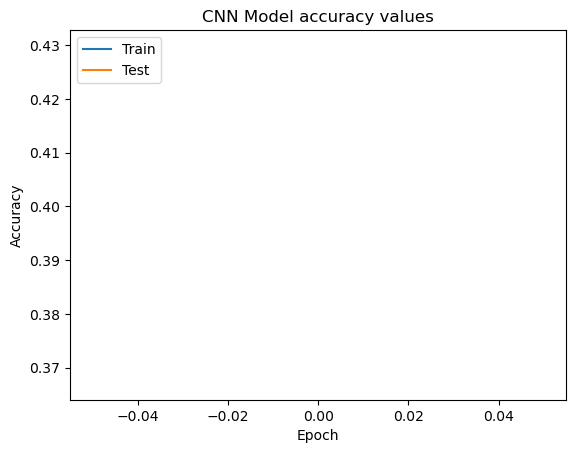

In [13]:
plt.plot(model_history.history["accuracy"])
plt.plot(model_history.history["val_accuracy"])
plt.title("CNN Model accuracy values")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"], loc="upper left")
plt.show()

# Model = Keras  Autotune


### **Validation**

In [7]:
# loaded_model = load_model("/mnt/Storage Drive/Projects/E-YRC/EYRC_2023/Task_2/Task_2B/vgg16_transfer_learning_model.keras")
# loaded_model = keras.models.load_model("/mnt/Storage Drive/Dataset/model-50eps-0.0002lr.keras")
loaded_model = load_model("/mnt/Storage/Dataset/Yolo-cls/model.h5")
print(loaded_model.summary())
val_dir = "/mnt/Storage/Dataset/Yolo-cls/val"
# dir_class = ["cbt","db","f","har","mww"]
IMG_SIZE = [160, 160]
class_labels = [
    "combat",
    "destroyedbuilding",
    "empty",
    "fire",
    "humanitarianaid",
    "militaryvehicles",
]
result_list = []
for classes in os.listdir(val_dir):
    total_images = 0
    correct = 0
    for images in os.listdir(val_dir + "/" + classes):
        if images.endswith(".jpg"):
            img_path = val_dir + "/" + classes + "/" + images
            # img = cv.resize(cv.imread(image),)
            # img = np.reshape(img, [1, IMG_SIZE[0], IMG_SIZE[1], 3])
            img = image.load_img(img_path, target_size=IMG_SIZE)
            # img_array = transform(img)
            img_array = image.img_to_array(img)
            img_array = np.expand_dims(img_array, axis=0)
            img_array = preprocess_input(img_array)
            probabilities = loaded_model.predict(img_array)
            predicted_class_index = np.argmax(probabilities)
            pred = class_labels[predicted_class_index]
            if (classes) == pred:
                correct += 1
            # if(classes =="cbt"):
            #     print(pred)
        total_images += 1
    result_list.append(
        str(
            str(correct)
            + "/"
            + str(total_images)
            + "    "
            + str(round((correct / total_images) * 100))
            + "%   --> "
            + classes
        )
    )
for i in result_list:
    print(i)
for images in os.listdir(
    "/mnt/Storage/Projects/E-YRC/EYRC_2023/Task_4/Task_4A/Arena_Images/"
):
    if images.endswith(".jpg"):
        img = image.load_img(
            "/mnt/Storage/Projects/E-YRC/EYRC_2023/Task_4/Task_4A/Arena_Images/"
            + images,
            target_size=IMG_SIZE,
        )
        img_array = transform(img)
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array = preprocess_input(img_array)
        probabilities = loaded_model.predict(img_array)
        predicted_class_index = np.argmax(probabilities)
        pred = class_labels[predicted_class_index]
        print(images + " --> " + pred)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 5, 5, 2048)        23564800  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_1 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 23577094 (89.94 MB)
Trainable params: 12294 (48.02 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________
None
1/1 [==============================] - 0s 67ms/step
10/10    100%   --> empty
0/45    0%   --> destroyed_buildings
0/41    0%   --> human_aid_rehabilitation
44/44    100%   --> combat
0/46    0%   --> m

In [16]:
# loaded_model = torch.load(
#     "/mnt/Storage Drive/Downloads/model_conv_36.pth"
# )
loaded_model = load_model(
    "/mnt/Storage/Projects/E-YRC/EYRC_2023/Task_2/Task_2B/vgg16_transfer_learning_model.keras"
)
# loaded_model = load_model("/mnt/Storage Drive/Downloads/vgg16_custom_80.keras")

val_dir = "/mnt/Storage/Dataset/Validate"
# dir_class = ["cbt","db","f","har","mww"]
for classes in os.listdir(val_dir):
    total_images = 0
    correct = 0
    for images in os.listdir(val_dir + "/" + classes):
        if images.endswith(".jpg"):
            image = preprocess_and_display(val_dir + "/" + classes + "/" + images, 0)
            # image = krs_load_image(val_dir + "/" + classes + "/" + images)
            # probabilities = loaded_model(image)
            probabilities = loaded_model.predict(image)
            # predicted_class_index = np.argmax(probabilities.detach().numpy())
            predicted_class_index = np.argmax(probabilities)
            pred = class_labels[predicted_class_index]
            if (classes) == pred:
                correct += 1
            # if(classes =="cbt"):
            #     print(pred)
        total_images += 1
    print(
        str(correct) + "/" + str(total_images),
        "    " + str(round((correct / total_images) * 100)) + "%",
        " --> ",
        classes,
    )


OSError: No file or directory found at /mnt/Storage/Projects/E-YRC/EYRC_2023/Task_2/Task_2B/vgg16_transfer_learning_model.keras